In [75]:
import scipy.io
import numpy as np
import networkx as nx
import os
import pandas as pd
from sklearn.cluster import SpectralClustering
import community  # Install using: pip install python-louvain
import matplotlib.pyplot as plt

In [94]:
##########################################################################################
#                                    HELPER FUNCTIONS
##########################################################################################

def get_graph_from_file(file, flag):
    fname1 = 'fungal_networks_data/Conductance_Text_Files/Sc_M_I_U_N_42d_1.txt'
    
    if flag:
        print(f'Reading the network file: {fname1}\n')
    
    return nx.read_weighted_edgelist(fname1, nodetype=str)


def graph_properties(G, flag, file):
    '''
    Parameters:
        G (graph)
        flag (int): flag=1 to print graph stats, 0 else
    '''
    
    n = len(G.nodes())
    m = len(G.edges())
    C = nx.transitivity(G)
    degrees = nx.degree(G)
    kis = [k for _,k in degrees]
    kstd = np.std(kis)
    kmean = np.mean(kis)
    max_edges = n * (n - 1) / 2
    edge_density = m / max_edges
    average_shortest_path_length = nx.average_shortest_path_length(G, weight='weight')
    
    betweenness = nx.betweenness_centrality(G, weight='weight')
    non_zero_betweenness = [value for value in betweenness.values() if value != 0]
    avg_betweenness_centrality = np.mean(non_zero_betweenness)

    total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))
    average_edge_weight = total_weight / G.number_of_edges()

    if flag:
        print("Number of nodes (n):", n)
        print("Number of edges (m):", m)
        print("Clustering Coefficient (C):", C)
        print("Mean Degree (kmean):", kmean)
        print("Degree STD (kstd):", kstd)
        print("Edge density (D):", edge_density)
        print("Average shortest path length: ", average_shortest_path_length)
        print("Average betweeness centrality: ", avg_betweenness_centrality)
        print("Average edge weight: ", average_edge_weight)
        print("\n")
        
    return [C,kstd,kmean,edge_density,average_shortest_path_length,
            avg_betweenness_centrality,average_edge_weight, file]


def get_all_vectors(directory, flag):
    '''
    Parameters:
        directory path (string)
        flag (int): flag=1 to print graph stats, 0 else
    '''
    files = os.listdir(directory)  # Slicing should be done after calling listdir()
    all_graphs = []
    all_graphs_properties = []
    
    flag_count = 0
    
    for file in files:
        file_pathway = directory+file
        if flag_count >= 5:
            flag = 0
            
        G = get_graph_from_file(file_pathway, flag) 
        p = graph_properties(G, flag, file)
        all_graphs.append(G)
        all_graphs_properties.append(p)
        flag_count += 1
        
    return all_graphs_properties

In [95]:
####### Helpers for clustering #######

def louvain_clustering(G, flag):
    partition = community.best_partition(G)
    num_clusters = len(set(partition.values())) # Count the number of unique community IDs\

    if flag:
        # Draw the graph with nodes colored by community
        pos = nx.spring_layout(G)  # Positions for all nodes
        plt.figure(figsize=(8, 6))

        # Draw nodes, coloring them by community
        node_colors = [partition[n] for n in G.nodes()]
        nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=20)

        plt.title("Graph with Nodes Colored by Community (Louvain Method)")
        plt.show()
        
    return partition, num_clusters

In [96]:
G = nx.karate_club_graph

In [97]:
fname1 = 'fungal_networks_data/Conductance_Text_Files/Sc_M_I_U_N_42d_1.txt'
G = get_graph_from_file(fname1, fname1)

Reading the network file: fungal_networks_data/Conductance_Text_Files/Sc_M_I_U_N_42d_1.txt



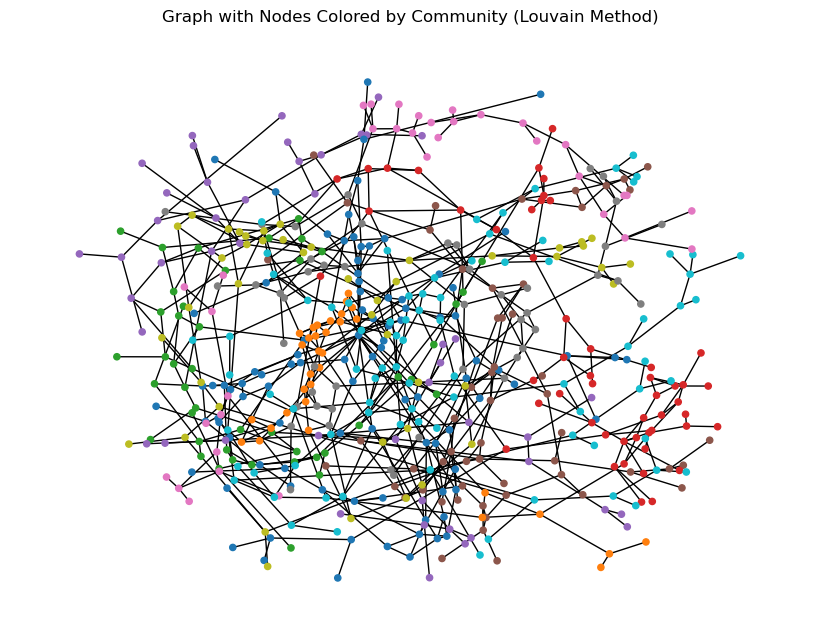

Number of nodes (n): 536
Number of edges (m): 689
Clustering Coefficient (C): 0.08066581306017925
Mean Degree (kmean): 2.5708955223880596
Degree STD (kstd): 1.3378153625625286
Edge density (D): 0.0048054121913795505
Average shortest path length:  0.9921940403124676
Average betweeness centrality:  0.03839205877954172
Average edge weight:  0.11330391872278674


Number of clusters = 33


In [98]:
#########    TEST HELPER FUNCTIONS FOR ONE FILE    #########

partition, num_clusters = louvain_clustering(G, 1)
graph_properties(G, 1, fname1)

print(f'Number of clusters = {num_clusters}')

In [99]:
#########     GET ALL GRAPHS AND PROPERTIES     #########
flag = 1
directory = 'fungal_networks_data/Conductance_Text_Files/'

gmatrix = get_all_vectors(directory, flag)
column_names = ['C', 'kstd', 'kmean', 'edge_density','average_shortest_path_length',
                'avg_betweenness_centrality','average_edge_weight','file']
df = pd.DataFrame(gmatrix, columns=column_names)

print(df)
print("Fin")

Reading the network file: fungal_networks_data/Conductance_Text_Files/Sc_M_I_U_N_42d_1.txt

Number of nodes (n): 536
Number of edges (m): 689
Clustering Coefficient (C): 0.08066581306017925
Mean Degree (kmean): 2.5708955223880596
Degree STD (kstd): 1.3378153625625286
Edge density (D): 0.0048054121913795505
Average shortest path length:  0.9921940403124676
Average betweeness centrality:  0.03839205877954172
Average edge weight:  0.11330391872278674


Reading the network file: fungal_networks_data/Conductance_Text_Files/Sc_M_I_U_N_42d_1.txt

Number of nodes (n): 536
Number of edges (m): 689
Clustering Coefficient (C): 0.08066581306017925
Mean Degree (kmean): 2.5708955223880596
Degree STD (kstd): 1.3378153625625286
Edge density (D): 0.0048054121913795505
Average shortest path length:  0.9921940403124676
Average betweeness centrality:  0.03839205877954172
Average edge weight:  0.11330391872278674


Reading the network file: fungal_networks_data/Conductance_Text_Files/Sc_M_I_U_N_42d_1.txt



KeyboardInterrupt: 